<a href="https://colab.research.google.com/github/AlbertoEli/UANL_Mineria_de_Datos/blob/main/Tecnicas_Equipo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio de técnicas de minería

Equipo: 4

Grupo: 001, lunes

Integrantes
*   1877283, Cavazos Huerta, Sandra María.				  
*   1869764, Elizondo Villarreal, Alberto.						
*   1867031, Sánchez Tovar, Arturo Isaac.				
*   1862646, Sepulveda Bermudez, Marlene Michel. 		
*   1877498, Villarreal Garza, Diana. 				   	


## 1. Busqueda de técnica a utilizar

En base a nuestros objetivos tanto principal como secundario, hemos optado por utilizar la técnica de "Series de tiempo". En base a esta técnica, generaremos las predicciones de la temperatura global, con el fin de conocer cómo se comportarán en un futuro. Debido a que las temperaturas globales se miden a lo largo del tiempo, se ajusta a la técnica de series de tiempo. 

Referencias de trabajos realizados en base a esta técnica: 
https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima/notebook

##2. Partes de código a aplicar

Primero se exportan las librerias a utilizar.




In [ ]:
from datetime import datetime
import numpy as np             
import pandas as pd            
import matplotlib.pylab as plt #visualizar datos
           
from statsmodels.tsa.stattools import adfuller #para la prueba adf-fuller aumentada 
from statsmodels.tsa.stattools import acf, pacf #para los correlogramas
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6 #para el tamaño de los graficos

Importación de datos a utilizar. En este caso, haremos uso de las temperaturas globales, con el fin de conocer el comportamiento esperado. 

In [ ]:
temp_g= pd.read_csv("GlobalTemperatures.csv")
temp_g.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


Con lo anterior, observamos que las columnas que nos interesan son "dt" que hace referencia al tiempo y "LandAverageTemperature". Esto ya que, es necesario el tiempo y la variable para aplicar la técnica de serie de tiempo. Creando una nueva base de datos con dichas columnas, y modificando el nombre de las columnas. 

In [ ]:
temp_g_a=temp_g
temp_g_a= temp_g_a.drop(["LandAverageTemperatureUncertainty","LandMaxTemperature", "LandMaxTemperatureUncertainty", "LandMinTemperature", "LandMinTemperatureUncertainty","LandAndOceanAverageTemperature", "LandAndOceanAverageTemperatureUncertainty"], 1)

temp_g_a = temp_g_a.rename(columns = {
    'dt' : 'Fecha',
    'LandAverageTemperature' : 'Prom_Temperatura_Tierra'
})

#eliminando datos nulos
temp_g_a = temp_g_a.dropna(axis = 0, how='any')
temp_g_a.head()


,Fecha,Prom_Temperatura_Tierra
0,1750-01-01,3.034
1,1750-02-01,3.083
2,1750-03-01,5.626
3,1750-04-01,8.490
4,1750-05-01,11.573


Visualizando la temperatura 

Text(0, 0.5, 'Temperatura')

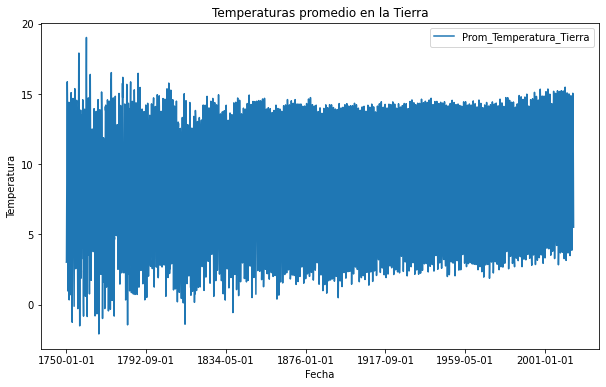

In [ ]:
temp_g_a.plot(x = 'Fecha', y = 'Prom_Temperatura_Tierra')
plt.title('Temperaturas promedio en la Tierra')
plt.ylabel('Temperatura')

Observando, el primer paso a realizar es checar si es estacionaria o no. Para ello, se comprueba si la seria es estacionaria en media y en varianza. Si es estacionaria en ambas, se dice que la serie es estacionaria sino se realizarán cambios con el fin de hacerla estacionaria. 

De manera visual:

In [ ]:
#Determinando la media 
rolmean = temp_g_a.rolling(window=12).mean() #12 es por la cantidad de meses en un año, ya que son datos mensuales.
print(rolmean)


      Prom_Temperatura_Tierra
0                         NaN
1                         NaN
2                         NaN
3                         NaN
4                         NaN
...                       ...
3187                 9.683750
3188                 9.676083
3189                 9.715333
3190                 9.775333
3191                 9.831000

[3180 rows x 1 columns]


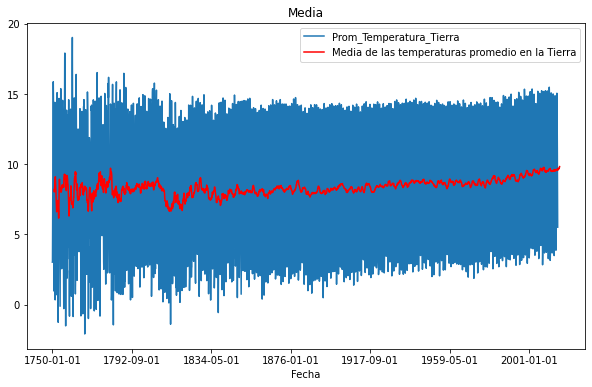

In [ ]:
#Graficando ambas
temp_g_a.plot(x = 'Fecha', y = 'Prom_Temperatura_Tierra')
mean = plt.plot(rolmean, color='red', label='Media de las temperaturas promedio en la Tierra')
plt.legend(loc='best')
plt.title('Media')
plt.show(block=False)

Por lo anterior, observamos que la media es no estacionaria. 
Para el caso de la varianza, se puede comprobar mediante la prueba de Dickey-Fuller aumentada. En la cual se tiene lo siguiente:
* H0: La serie no es estacionaria en varianza 
* H1: La serie es estacionaria en varianza 
* Criterio de rechazo: Rechazo H0 si Pvalor < alfa=0.05



In [ ]:
#Prueba de Dickey-Fuller aumentada: 
print('Prueba de Dickey-Fuller aumentada:')
dftest = adfuller(temp_g_a['Prom_Temperatura_Tierra'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Prueba de Dickey-Fuller aumentada:
Test Statistic                   -3.991678
p-value                           0.001455
#Lags Used                       28.000000
Number of Observations Used    3151.000000
Critical Value (1%)              -3.432427
Critical Value (5%)              -2.862458
Critical Value (10%)             -2.567259
dtype: float64


Ya que el P-valor=0.001455 < 0.05. Se rechaza H0. La serie es estacionaria en varianza.

Debido a que la serie es estacionaria en varianza, pero no en media, la serie no es estacionaria. Se deben hacer cambios para corregir la serie a una estacionaria. 

El primer cambio a realizar es la diferenciación. 

In [ ]:
temp_g_n=temp_g_a["Prom_Temperatura_Tierra"].diff()
temp_g_n = pd.DataFrame(temp_g_n)

#eliminando datos nulos
temp_g_n = temp_g_n.dropna(axis = 0, how='any')

temp_g_n.head()


,Prom_Temperatura_Tierra
1,0.049
2,2.543
3,2.864
4,3.083
5,1.364


Se revisa si la nueva serie ya es estacionaria. 

In [ ]:
#Determinando la media 
rolmean = temp_g_n.rolling(window=12).mean() #12 es por la cantidad de meses en un año, ya que son datos mensuales.
print(rolmean)

      Prom_Temperatura_Tierra
1                         NaN
2                         NaN
3                         NaN
4                         NaN
5                         NaN
...                       ...
3187                -0.010000
3188                -0.007667
3189                 0.039250
3190                 0.060000
3191                 0.055667

[3179 rows x 1 columns]


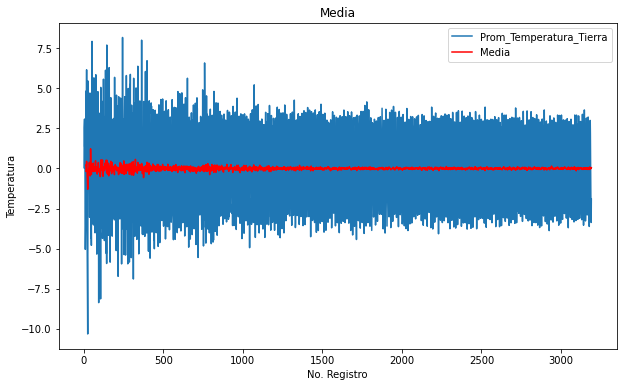

In [ ]:
#Graficando ambas
temp_g_n.plot(y = 'Prom_Temperatura_Tierra')
mean = plt.plot(rolmean, color='red', label='Media')
plt.legend(loc='best')
plt.title('Media')
plt.ylabel('Temperatura')
plt.xlabel('No. Registro')
plt.show(block=False)

In [ ]:
#Prueba de Dickey-Fuller aumentada: 
print('Prueba de Dickey-Fuller aumentada:')
dftest = adfuller(temp_g_n['Prom_Temperatura_Tierra'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Prueba de Dickey-Fuller aumentada:
Test Statistic                -1.636061e+01
p-value                        2.873101e-29
#Lags Used                     2.700000e+01
Number of Observations Used    3.151000e+03
Critical Value (1%)           -3.432427e+00
Critical Value (5%)           -2.862458e+00
Critical Value (10%)          -2.567259e+00
dtype: float64


Ya que el P-valor= 2.873101e-29 < 0.05. Se rechaza H0. La serie es estacionaria en varianza.

Debido a que la serie es estacionaria en varianza y en media, la serie corregida una vez por diferenciación es estacionaria. 

Ya que la serie corregida una vez por diferenciación es estacionaria, se procede a buscar el modelo que mejor se ajuste a los datos.

In [ ]:
import statsmodels.api as sm

aic_ar=10000000
orden_ar=(0,0,0)

for i in range(0,15):
  model = ARIMA(temp_g_n['Prom_Temperatura_Tierra'], order=(i,0,0))
  results_ARIMA = model.fit(disp=-1)
  aic_x=results_ARIMA.aic
  if aic_ar>aic_x:
    aic_ar=aic_x
    orden_ar=(i,0,0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was pro

In [ ]:
print("El orden es:", orden_ar, "y el AIC es: ", aic_ar)

El orden es: (14, 0, 0) y el AIC es:  8034.410985945601


Plotting AR model


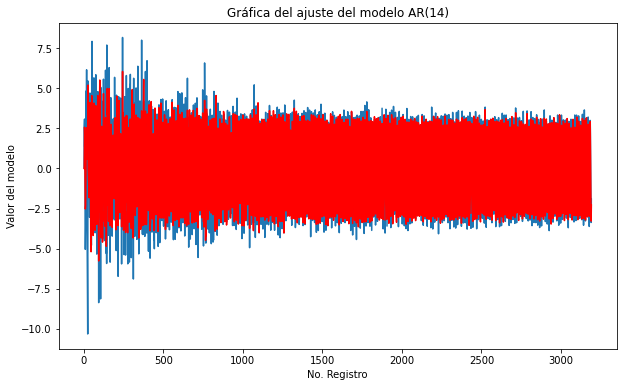

In [ ]:
#Gráfica de valores ajustados por el modelo 
plt.plot(temp_g_n)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('Gráfica del ajuste del modelo AR(14)')
plt.ylabel('Valor del modelo')
plt.xlabel('No. Registro')
print('Plotting AR model')

Realizando las predicciones en base al modelo seleccionado. En este caso el modelo que mejor se ajusta a los datos corregidos es un AR(14). Con el fin de generar predicciones en base a los datos originales se hace uso de un modelo ARIMA (14,1,0), en donde el parámetro p=14 proviene del modelo AR y el parámetro d=1 proviene de las correcciones realizadas. 

In [ ]:
import statsmodels.api as sm

model1 = ARIMA(temp_g_a['Prom_Temperatura_Tierra'], order=(14,1,0))
results_ARIMA1 = model1.fit(disp=-1)
print("El modelo ARIMA (14,1,0) tiene un AIC de:", results_ARIMA1.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


El modelo ARIMA (14,1,0) tiene un AIC de: 8034.410985945601


In [ ]:
#Realizando las predicciones
predictions_ARIMA1= pd.Series(results_ARIMA1.fittedvalues, copy=True)
print(predictions_ARIMA1)

1       0.000472
2       0.032915
3       1.823647
4       2.575730
5       2.198160
          ...   
3187   -0.461065
3188   -1.940681
3189   -2.858258
3190   -3.280736
3191   -2.278933
Length: 3179, dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Text(0.5, 0, 'No. Registro')

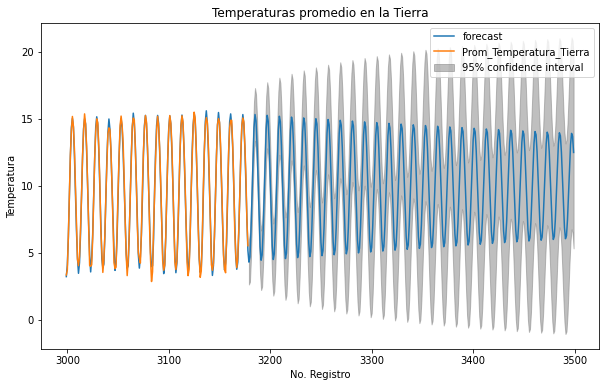

In [ ]:
#Gráfica de las predicciones
results_ARIMA1.plot_predict(3000,3500) 
plt.title('Temperaturas promedio en la Tierra')
plt.ylabel('Temperatura')
plt.xlabel('No. Registro')

In [ ]:
#Residuales
Re=-results_ARIMA.fittedvalues+temp_g_n['Prom_Temperatura_Tierra']
Re

1       0.048528
2       2.510085
3       1.040353
4       0.507270
5      -0.834160
          ...   
3187    0.165065
3188    0.184681
3189    0.660258
3190   -0.087264
3191    0.363933
Length: 3179, dtype: float64

## 3. Métricas de evaluación


Con el fin de evaluar las predicciones de nuestro modelo, se pueden obtener ciertas métricas de evaluación que miden el desempeño del modelo seleccionado. 

###1. AIC

El criterio de información de Akaike (AIC) es una medida de la bondad de ajuste de un modelo estadístico. Para nuestro modelo, sirve para comparar modelos y seleccionar el más adecuado. En lineas anteriores, el modelo propuesto fue seleccionado comparando el AIC y seleccionando el menor. 

In [ ]:
print("El AIC del modelo propuesto es: ",aic_ar)

El AIC del modelo propuesto es:  8034.410985945601


El AIC del modelo propuesto es el más pequeño comparando otros modelos para ajustarlos a los datos originales. 

###2. Error Porcentual Absoluto Medio

El Error Porcentual Absoluto Medio es un indicador del desempeño de los pronósticos que mide el tamaño del error (absoluto) en términos porcentuales. Es de gran utilidad dicha metrica de evaluación ya que nos indica el porcentaje de error del modelo propuesto. 

In [ ]:
error=np.mean(np.abs((temp_g_n['Prom_Temperatura_Tierra'] - results_ARIMA.fittedvalues) / temp_g_n['Prom_Temperatura_Tierra'])) * 100
error= round(error, 6)
print("El error porcentual absoluto medio es: ", error, "%", sep="")

El error porcentual absoluto medio es: 64.212179%


###3. Error Cuadrático Medio

El error cuadrático medio mide la diferencia que hay entre dos conjuntos de datos, para este es preferible tener valores cercanos al 0. Decidimos hacer uso de él, ya que nos brinda el error promedio entre los datos originales y los datos generados por el modelo propuesto. 

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score 

error2=mean_squared_error(temp_g_n['Prom_Temperatura_Tierra'],results_ARIMA.fittedvalues)
error2= round(error2, 6)
print("El error cuadrático medio es: ", error2)

El error cuadrático medio es:  0.727204


##4. Conclusion global

En base a las predicciones realizadas con el modelo propuesto, podemos destacar que las predicciones de la temperatura promedio global en los siguientes 10 años no presentan un cambio en su tendencia. Sin embargo, en una vista general, en los años de 1750-2015 se observa una tendencia a la alza. 

En base a lo anterior, se espera que la temperatura global aumente gradualmente. Cabe destacar, que aunque el cambio sea paulatino, una alteración mínima de éste puede afectar en gran medida a los ecosistemas de la Tierra. 

Por ello, podemos concluir que la temperatura promedio global desde los últimos 265 años ha aumentado, por lo que se espera que la tendencia siga a la alza al largo plazo. 

En base a las métricas de evaluación podemos destacar que existe un error porcentual absoluto medio del 64.21%, mientras que el AIC obtenido es el mejor de los modelos autorregresivos. Para mejorar el procentaje de error y el AIC, se puede optar por hacer uso de modelos autorregresivos de media móvil (ARMA), esperando que éstos disminuyan. 